## Import library

In [1]:
import pandas as pd  # to store data as dataframe
import numpy as np  # for numerical calculations such as histogramming
import matplotlib.pyplot as plt  # for plotting

You can check the version of these packages by checking the __version__ attribute.

In [2]:
np.__version__

'1.22.3'

Let’s set the random seed that we’ll be using. This reduces the randomness when you re-run the notebook

In [3]:
seed_value = 420  # 42 is the answer to life, the universe and everything
from numpy.random import seed  # import the function to set the random seed in NumPy

seed(seed_value)  # set the seed value for random numbers in NumPy

## Dataset Used

The dataset we will use in this tutorial is simulated ATLAS data. Each event corresponds to 4 detected leptons: some events correspond to a Higgs Boson decay (signal) and others do not (background). Various physical quantities such as lepton charge and transverse momentum are recorded for each event. The analysis in this tutorial loosely follows the [discovery of the Higgs Boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X).

In [4]:
# In this notebook we only process the main signal ggH125_ZZ4lep and the main background llll,
# for illustration purposes.
# You can add other backgrounds after if you wish.
samples = ["llll", "ggH125_ZZ4lep"]

## Exploring the Dataset

Here we will format the dataset 
(x<sub>i</sub>,y<sub>i</sub>) so we can explore! First, we need to open our data set and read it into pandas DataFrames.



In [5]:
# get data from files

DataFrames = {}  # define empty dictionary to hold dataframes
for s in samples:  # loop over samples
    DataFrames[s] = pd.read_csv("4Zlepton/" + s + ".csv")  # read .csv file

In [6]:
DataFrames["ggH125_ZZ4lep"]  # print signal data to take a look

,entry,lep_pt_0,lep_pt_1,lep_pt_2,lep_pt_3,lep_eta_0,lep_eta_1,lep_eta_2,lep_eta_3,lep_phi_0,...,lep_ptconerel_3,lep_etconerel_0,lep_etconerel_1,lep_etconerel_2,lep_etconerel_3,min_mll,mZ1,mZ2,mllll,totalWeight
0,0,51.905457,41.248570,16.397670,7.471228,-0.925709,-0.823695,-0.486417,0.266718,-2.774290,...,0.000000,-0.005114,0.034386,0.071266,-0.115843,9.953831,92.628607,23.311568,122.689157,0.000018
1,1,41.430645,40.307168,16.133789,7.481857,-1.233182,-0.396434,-0.541508,-0.302179,0.449031,...,0.151779,-0.030370,0.017931,0.030408,-0.120944,17.821408,86.697751,17.821408,113.659172,0.000034
2,2,33.646711,27.313271,20.035949,16.472641,-0.032324,-0.044153,0.067013,1.859531,-2.077223,...,0.000000,0.016144,-0.012675,0.101923,0.017772,32.122807,62.627431,32.122807,125.399958,0.000040
3,3,77.118562,27.845740,17.726541,14.714521,0.514764,0.845311,2.189158,0.179711,0.115437,...,0.000000,-0.005004,-0.007781,0.000000,0.034991,29.143731,84.535069,29.143731,123.645105,0.000059
4,4,161.909219,53.367754,25.596689,18.864479,-1.037354,-0.821728,-1.261883,0.126195,-0.161717,...,0.000000,0.018625,-0.000264,-0.001246,-0.002172,39.159591,68.958081,48.500839,123.518264,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164711,164711,32.143482,24.158068,17.203547,14.358152,-1.003832,0.609448,0.876340,1.039745,-0.417631,...,0.000000,-0.020921,0.040304,-0.001333,0.010283,25.926057,62.697352,39.612517,123.352912,0.000019
164712,164712,39.488273,33.694094,32.709998,14.797520,0.184790,0.799441,-0.454989,-1.167309,-0.747386,...,0.000000,0.040552,-0.000592,0.018882,-0.019414,30.654450,56.876117,30.654450,122.652688,0.000054
164713,164713,63.284211,22.707840,15.635994,14.873250,0.935591,0.184483,0.174508,2.128866,-1.503719,...,0.000000,0.010497,-0.015776,-0.022911,-0.003570,30.952590,66.649322,37.686620,124.312299,0.000071
164714,164714,52.538805,40.321457,25.766850,19.381920,0.880250,1.205615,1.701138,0.853039,-2.060255,...,0.000000,0.017046,-0.013661,0.057185,0.000224,19.868087,88.412652,19.868087,124.105421,0.000060


Before diving into machine learning, think about whether there are any things you should do to clean up your data. In the case of this Higgs analysis, Higgs boson decays should produce 4 electrons or 4 muons or 2 electrons and 2 muons. Let’s define a function to keep only events which produce 4 electrons or 4 muons or 2 electrons and 2 muons.

In [7]:
# cut on lepton type
def cut_lep_type(lep_type_0, lep_type_1, lep_type_2, lep_type_3):
    # first lepton is [0], 2nd lepton is [1] etc
    # for an electron lep_type is 11
    # for a muon lep_type is 13
    # only want to keep events where one of eeee, mumumumu, eemumu
    sum_lep_type = lep_type_0 + lep_type_1 + lep_type_2 + lep_type_3
    if sum_lep_type == 44 or sum_lep_type == 48 or sum_lep_type == 52:
        return True
    else:
        return False

# cut on lepton charge
def cut_lep_charge(lep_charge_0,lep_charge_1,lep_charge_2,lep_charge_3):
# only want to keep events where sum of lepton charges is 0
    sum_lep_charge = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    if sum_lep_charge==0: return True
    else: return False

We then need to apply this function on our DataFrames.

In [8]:
# apply cut on lepton type
for s in samples:
    # cut on lepton type using the function cut_lep_type defined above
    DataFrames[s] = DataFrames[s][
        np.vectorize(cut_lep_type)(
            DataFrames[s].lep_type_0,
            DataFrames[s].lep_type_1,
            DataFrames[s].lep_type_2,
            DataFrames[s].lep_type_3,
        )
    ]

In [9]:
DataFrames["ggH125_ZZ4lep"]  # print signal data to take a look

,entry,lep_pt_0,lep_pt_1,lep_pt_2,lep_pt_3,lep_eta_0,lep_eta_1,lep_eta_2,lep_eta_3,lep_phi_0,...,lep_ptconerel_3,lep_etconerel_0,lep_etconerel_1,lep_etconerel_2,lep_etconerel_3,min_mll,mZ1,mZ2,mllll,totalWeight
0,0,51.905457,41.248570,16.397670,7.471228,-0.925709,-0.823695,-0.486417,0.266718,-2.774290,...,0.000000,-0.005114,0.034386,0.071266,-0.115843,9.953831,92.628607,23.311568,122.689157,0.000018
1,1,41.430645,40.307168,16.133789,7.481857,-1.233182,-0.396434,-0.541508,-0.302179,0.449031,...,0.151779,-0.030370,0.017931,0.030408,-0.120944,17.821408,86.697751,17.821408,113.659172,0.000034
2,2,33.646711,27.313271,20.035949,16.472641,-0.032324,-0.044153,0.067013,1.859531,-2.077223,...,0.000000,0.016144,-0.012675,0.101923,0.017772,32.122807,62.627431,32.122807,125.399958,0.000040
3,3,77.118562,27.845740,17.726541,14.714521,0.514764,0.845311,2.189158,0.179711,0.115437,...,0.000000,-0.005004,-0.007781,0.000000,0.034991,29.143731,84.535069,29.143731,123.645105,0.000059
4,4,161.909219,53.367754,25.596689,18.864479,-1.037354,-0.821728,-1.261883,0.126195,-0.161717,...,0.000000,0.018625,-0.000264,-0.001246,-0.002172,39.159591,68.958081,48.500839,123.518264,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164711,164711,32.143482,24.158068,17.203547,14.358152,-1.003832,0.609448,0.876340,1.039745,-0.417631,...,0.000000,-0.020921,0.040304,-0.001333,0.010283,25.926057,62.697352,39.612517,123.352912,0.000019
164712,164712,39.488273,33.694094,32.709998,14.797520,0.184790,0.799441,-0.454989,-1.167309,-0.747386,...,0.000000,0.040552,-0.000592,0.018882,-0.019414,30.654450,56.876117,30.654450,122.652688,0.000054
164713,164713,63.284211,22.707840,15.635994,14.873250,0.935591,0.184483,0.174508,2.128866,-1.503719,...,0.000000,0.010497,-0.015776,-0.022911,-0.003570,30.952590,66.649322,37.686620,124.312299,0.000071
164714,164714,52.538805,40.321457,25.766850,19.381920,0.880250,1.205615,1.701138,0.853039,-2.060255,...,0.000000,0.017046,-0.013661,0.057185,0.000224,19.868087,88.412652,19.868087,124.105421,0.000060


In [10]:
# apply cut on lepton charge
for s in samples:
    # cut on lepton charge using the function cut_lep_charge defined above
    DataFrames[s] = DataFrames[s][ np.vectorize(cut_lep_charge)(DataFrames[s].lep_charge_0,
                                                    	    DataFrames[s].lep_charge_1,
                                                    	    DataFrames[s].lep_charge_2,
                                                    	    DataFrames[s].lep_charge_3) ]
DataFrames['ggH125_ZZ4lep'] # print signal data to take a look

,entry,lep_pt_0,lep_pt_1,lep_pt_2,lep_pt_3,lep_eta_0,lep_eta_1,lep_eta_2,lep_eta_3,lep_phi_0,...,lep_ptconerel_3,lep_etconerel_0,lep_etconerel_1,lep_etconerel_2,lep_etconerel_3,min_mll,mZ1,mZ2,mllll,totalWeight
0,0,51.905457,41.248570,16.397670,7.471228,-0.925709,-0.823695,-0.486417,0.266718,-2.774290,...,0.000000,-0.005114,0.034386,0.071266,-0.115843,9.953831,92.628607,23.311568,122.689157,0.000018
1,1,41.430645,40.307168,16.133789,7.481857,-1.233182,-0.396434,-0.541508,-0.302179,0.449031,...,0.151779,-0.030370,0.017931,0.030408,-0.120944,17.821408,86.697751,17.821408,113.659172,0.000034
2,2,33.646711,27.313271,20.035949,16.472641,-0.032324,-0.044153,0.067013,1.859531,-2.077223,...,0.000000,0.016144,-0.012675,0.101923,0.017772,32.122807,62.627431,32.122807,125.399958,0.000040
3,3,77.118562,27.845740,17.726541,14.714521,0.514764,0.845311,2.189158,0.179711,0.115437,...,0.000000,-0.005004,-0.007781,0.000000,0.034991,29.143731,84.535069,29.143731,123.645105,0.000059
4,4,161.909219,53.367754,25.596689,18.864479,-1.037354,-0.821728,-1.261883,0.126195,-0.161717,...,0.000000,0.018625,-0.000264,-0.001246,-0.002172,39.159591,68.958081,48.500839,123.518264,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164711,164711,32.143482,24.158068,17.203547,14.358152,-1.003832,0.609448,0.876340,1.039745,-0.417631,...,0.000000,-0.020921,0.040304,-0.001333,0.010283,25.926057,62.697352,39.612517,123.352912,0.000019
164712,164712,39.488273,33.694094,32.709998,14.797520,0.184790,0.799441,-0.454989,-1.167309,-0.747386,...,0.000000,0.040552,-0.000592,0.018882,-0.019414,30.654450,56.876117,30.654450,122.652688,0.000054
164713,164713,63.284211,22.707840,15.635994,14.873250,0.935591,0.184483,0.174508,2.128866,-1.503719,...,0.000000,0.010497,-0.015776,-0.022911,-0.003570,30.952590,66.649322,37.686620,124.312299,0.000071
164714,164714,52.538805,40.321457,25.766850,19.381920,0.880250,1.205615,1.701138,0.853039,-2.060255,...,0.000000,0.017046,-0.013661,0.057185,0.000224,19.868087,88.412652,19.868087,124.105421,0.000060


## Plot some input variables
In any analysis searching for signal one wants to optimise the use of various input variables. Often, this optimisation will be to find the best signal to background ratio. Here we define histograms for the variables that we’ll look to optimise.

In [11]:
lep_pt_2 = {  # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    "bin_width": 1,  # width of each histogram bin
    "num_bins": 13,  # number of histogram bins
    "xrange_min": 7,  # minimum on x-axis
    "xlabel": r"$lep\_pt$[2] [GeV]",  # x-axis label
}

In [12]:
lep_pt_1 = { # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':28, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}

Now we define a dictionary for the histograms we want to plot.

In [13]:
SoverB_hist_dict = {
    "lep_pt_2": lep_pt_2,
    "lep_pt_1": lep_pt_1,
}  # add a histogram here if you want it plotted

Now let’s take a look at those variables. Because the code is a bit long, we pre-defined a function for you, to illustrate the optimum cut value on individual variables, based on signal to background ratio. Let’s call the function to illustrate the optimum cut value on individual variables, based on signal to background ratio. You can check out the function definition [–>here<–](https://www.kaggle.com/code/meirinevans/my-functions)

We’re not doing any machine learning just yet! We’re looking at the variables we’ll later use for machine learning.

In [14]:
def plot_SoverB(DataFrames, SoverB_hist_dict):
    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = [] # define list to hold the signal histogram entries
        background_x = [] # define list to hold the background histogram entries
        for key in DataFrames: # loop over samples
            if key!='data': # only Monte Carlo should pass this
                if 'H125' in key or 'ttZ' in key: # only signal should pass this
                    signal_x = [*signal_x, *DataFrames[key][x_variable] ] # signal histogram entries
                else: # only background should pass this
                    background_x = [*background_x, *DataFrames[key][x_variable] ] # background histogram entries

    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        background_heights = distributions_axes.hist(background_x, bins=bin_edges, 
                                                     color='blue', label='Total background',
                                                     histtype='step', # lineplot that's unfilled
                                                     density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='orange',
                                                 label='Signal', 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.93, # y
                 'ATLAS Open Data', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.88, # y
                 'for education', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 style='italic',
                 fontsize=8 )  
    
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            signal_weights_passing_cut = 0 # start counter for signal weight passing cut
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for key in DataFrames: # loop over samples
                if key!='data': # only Monte Carlo should pass this
                    if 'H125' in key or 'ttZ' in key: # only signal should pass this
                        signal_weights_passing_cut += sum(DataFrames[key][DataFrames[key][x_variable]>cut_value].totalWeight)
                    else: # only background should pass this
                        background_weights_passing_cut += sum(DataFrames[key][DataFrames[key][x_variable]>cut_value].totalWeight)
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        
        plt.show() # show S/B plot
    
    return


def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend


# function to write the definition of our function to the file
#def write_function_to_file(function, file):
#    if os.path.exists(file):
#        append_write = 'a' # append if already exists
#    else:
#        append_write = 'w' # make a new file if not
#    with open(file, append_write) as file:
#        function_definition = inspect.getsource(function)
#        file.write(function_definition)

# write our functions to our output file        
#write_function_to_file(plot_SoverB, "my_functions.py")
#write_function_to_file(compare_train_test, "my_functions.py")

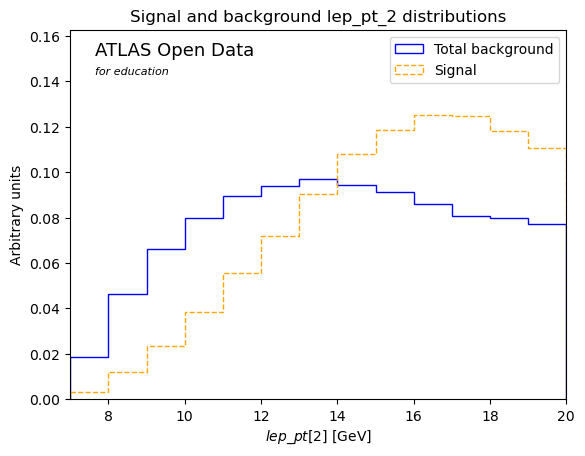

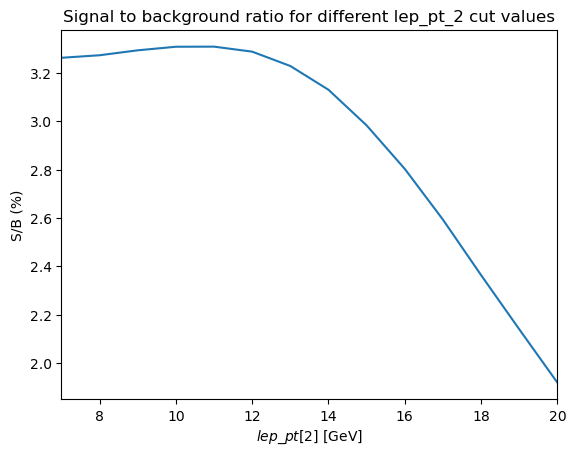

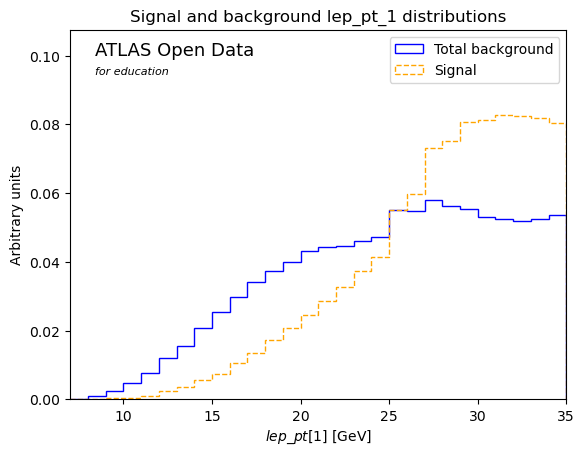

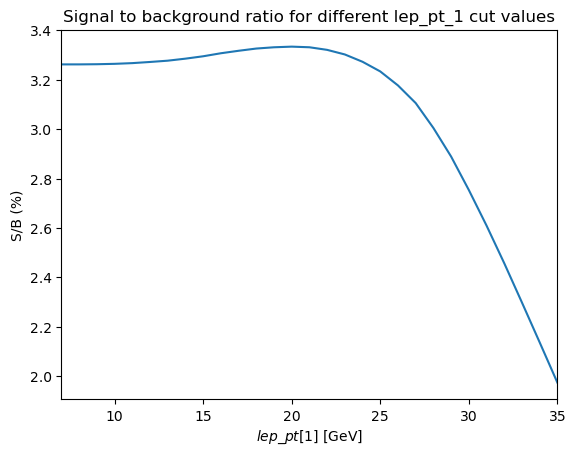

In [15]:
#from my_functions import plot_SoverB

plot_SoverB(DataFrames, SoverB_hist_dict)

Let’s talk through the lep_pt_2 plots.

Imagine placing a cut at 7 GeV in the distributions of signal and background (1st plot). This means keeping all events above 7 GeV in the signal and background histograms.
We then take the ratio of the number of signal events that pass this cut, to the number of background events that pass this cut. This gives us a starting value for S/B (2nd plot).
We then increase this cut value to 8 GeV, 9 GeV, 10 GeV, 11 GeV, 12 GeV. Cuts at these values are throwing away more background than signal, so S/B increases.
There comes a point around 13 GeV where we start throwing away too much signal, thus S/B starts to decrease.
Our goal is to find the maximum in S/B, and place the cut there. You may have thought the maximum would be where the signal and background cross in the upper plot, but remember that the lower plot is the signal to background ratio of everything to the right of that x-value, not the signal to background ratio at that x-value.

## Format the data for machine learning

It’s almost time to build a machine learning model! First we choose the variables to use in our machine learning model.



In [16]:
ML_inputs = ["lep_pt_1", "lep_pt_2"]  # list of features for ML model

The data type is currently a pandas DataFrame: we now need to convert it into a NumPy array so that it can be used in scikit-learn and TensorFlow during the machine learning process. Note that there are many ways that this can be done: in this tutorial we will use the NumPy concatenate functionality to format our data set. For more information, please see the NumPy documentation on concatenate. We will briefly walk through the code in this tutorial.



In [17]:
#  Organise data ready for the machine learning model

# for sklearn data are usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples

all_MC = []  # define empty list that will contain all features for the MC
for s in samples:  # loop over the different samples
    if s != "data":  # only MC should pass this
        all_MC.append(
            DataFrames[s][ML_inputs]
        )  # append the MC dataframe to the list containing all MC features
X = np.concatenate(
    all_MC
)  # concatenate the list of MC dataframes into a single 2D array of features, called X

all_y = (
    []
)  # define empty list that will contain labels whether an event in signal or background
for s in samples:  # loop over the different samples
    if s != "data":  # only MC should pass this
        if "H125" in s:  # only signal MC should pass this
            all_y.append(
                np.ones(DataFrames[s].shape[0])
            )  # signal events are labelled with 1
        else:  # only background MC should pass this
            all_y.append(
                np.zeros(DataFrames[s].shape[0])
            )  # background events are labelled 0
y = np.concatenate(
    all_y
)  # concatenate the list of labels into a single 1D array of labels, called y

This takes in DataFrames and spits out a NumPy array consisting of only the DataFrame columns corresponding to ML_inputs.

Now we separate our data into a training and test 

In [18]:
# This will split your data into train-test sets: 67%-33%.
# It will also shuffle entries so you will not get the first 67% of X for training
# and the last 33% for testing.
# This is particularly important in cases where you load all signal events first
# and then the background events.

# Here we split our data into two independent samples.
# The split is to create a training and testing set.
# The first will be used for classifier training and the second to evaluate its performance.

from sklearn.model_selection import train_test_split

# make train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed_value
)  # set the random seed for reproducibility

Machine learning models may have difficulty converging before the maximum number of iterations allowed if the data aren’t normalized. Note that you must apply the same scaling to the test set for meaningful results (we’ll apply the scaling to the test set in the next step). There are a lot of different methods for normalization of data. We will use the built-in [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for standardization. The `StandardScaler` ensures that all numerical attributes are scaled to have a mean of 0 and a standard deviation of 1 before they are fed to the machine learning model. This type of preprocessing is common before feeding data into machine learning models and is especially important for neural networks.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # initialise StandardScaler

# Fit only to the training data
scaler.fit(X_train)

StandardScaler()

Now we will use the scaling to apply the transformations to the data.

In [20]:
X_train_scaled = scaler.transform(X_train)

Apply the same scaler transformation to X_test and X.

In [21]:
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

Now we are ready to examine various models 
*f*
 for predicting whether an event corresponds to a signal event or a background event.

## Models


In this section we will examine 2 different machine learning models 
*f*
 for classification: the random forest (RF)

In the previous, we created a training and test dataset. Lets use these datasets to train a random forest.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

RF_clf = RandomForestClassifier(
    criterion="gini", max_depth=8, n_estimators=30, random_state=seed_value
)  # initialise your random forest classifier
RF_clf.fit(X_train_scaled, y_train)  # fit to the training data
y_pred_RF = RF_clf.predict(X_test_scaled)  # make predictions on the test data

# See how well the classifier does
print(accuracy_score(y_test, y_pred_RF))

0.8166721931162544


In this section we will check whether there has been any overfitting during the model training phase. As discussed in the lesson on Mathematical Foundations, overfitting can be an unwanted fly in the ointment, so it should be avoided!

Comparing a machine learning model’s output distribution for the training and testing set is a popular way in High Energy Physics to check for overfitting. The compare_train_test() method will plot the shape of the machine learning model’s decision function for each class, as well as overlaying it with the decision function in the training set.

There are techniques to prevent overfitting.

The code to plot the overfitting check is a bit long, so once again you can see the function definition.

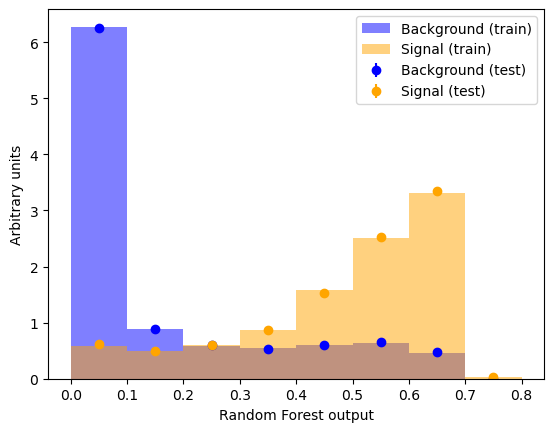

In [23]:
compare_train_test(
    RF_clf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest output"
)

Our orange signal dots (test set) nicely overlap with our orange signal histogram bars (training set). The same goes for the blue background. This overlap indicates that no overtaining is present. 

If overfitting were present, the dots (test set) would be very far from the bars (training set). Look back to the figure in the Overfitting section of the Mathematical Foundations lesson for a brief explanation. Overfitting might look something like this

<img src="Screenshot 2022-10-17 185156.png" style="width:600px;height:400px;">


## Alternative Metrics

As seen in the previous section, accuracy is typically not the preferred metric for classifiers. In this section we will define some new metrics. Let TP, FP, TN, FN be the number of true positives, false positives, true negatives, and false negatives classified using a given model. Note that in this terminology, a background event is considered negative while a signal event is considered positive.

TP: Signal events correctly identified as signal events
FP: Background events incorrectly identified as signal events
TN: Background events correctly identified as background events
FN: Signal events incorrectly identified as background events
Before getting into these metrics, it is important to note that a machine learning binary classifier is capable of providing a probability that a given instance corresponds to a signal or background (i.e. it would output [0.2, 0.8] where the first index corresponds to background and the second index as signal).

It is then up to a human user to specify the probability threshold at which something is classified as a signal. For example, you may want the second index to be greater than 0.999 to classify something as a signal. As such, the TP, FP, TN and FN can be altered for a given machine learning classifier based on the threshold requirement for classifying something as a signal event.

## Precision

Precision is defined as

precision= TP/(TP+FP)

It is the ratio of all things that were correctly classified as positive to all things that were classified as positive. Precision itself is an imperfect metric: a trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (1/1=100%) but this would not be useful. This is equivalent to having a very high threshold. As such, precision is typically combined with another metric: recall.

## Recall (True Positive Rate)

Recall is defined as

recall= TP/(TP+FN)

It is the ratio of all things that were correctly classified as positive to all things that should have been classified as positive. Recall itself is also an imperfect metric: a trivial way to have perfect recall is to classify everything as positive; doing so, however, would result in a poor precision score. This is equivalent to having a very low threshold. As such, precision and recall need to be considered together.

##  F1 score

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

## Accuracy

Model accuracy is a machine learning classification model performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations. In other words, accuracy tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions. For example: Let’s assume that you were testing your machine learning model with a dataset of 100 records and that your machine learning model predicted all 90 of those instances correctly. The accuracy metric, in this case, would be: (90/100) = 90%. The accuracy rate is great but it doesn’t tell us anything about the errors our machine learning models make on new data we haven’t seen before.

Mathematically, it represents the ratio of the sum of true positive and true negatives out of all the predictions.

Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)

In [24]:
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest Report
print(classification_report(y_test, y_pred_RF, target_names=["background", "signal"]))

              precision    recall  f1-score   support

  background       0.88      0.89      0.88    172891
      signal       0.62      0.59      0.60     53294

    accuracy                           0.82    226185
   macro avg       0.75      0.74      0.74    226185
weighted avg       0.81      0.82      0.82    226185



## Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred_RF)
cm

array([[153321,  19570],
       [ 21896,  31398]], dtype=int64)

<AxesSubplot:>

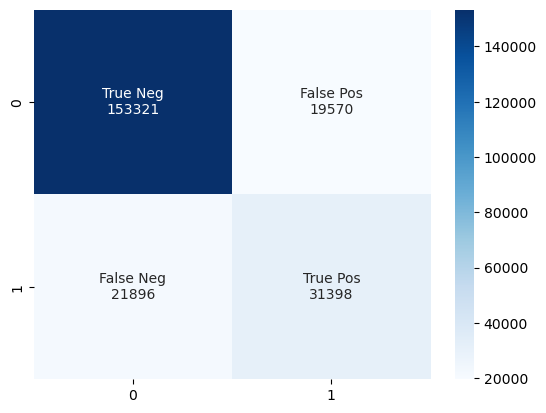

In [26]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
#group_percentages = [“{0:.2%}”.format(value) for value in
#                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,
          group_counts
          #group_percentages
          )
          ]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

Let’s get the decisions of the random forest classifier.

In [27]:
decisions_rf = RF_clf.predict_proba(X_test_scaled)[
    :, 1
]  # get the decisions of the random forest

## The ROC Curve

The Receiver Operating Characteristic (ROC) curve is a plot of the recall (or true positive rate) vs. the false positive rate: the ratio of negative instances incorrectly classified as positive. A classifier may classify many instances as positive (i.e. has a low tolerance for classifying something as positive), but in such an example it will probably also incorrectly classify many negative instances as positive as well. The false positive rate is plotted on the x-axis of the ROC curve and the true positive rate on the y-axis; the threshold is varied to give a parameteric curve. A random classifier results in a line. Before we look at the ROC curve, let’s examine the following plot

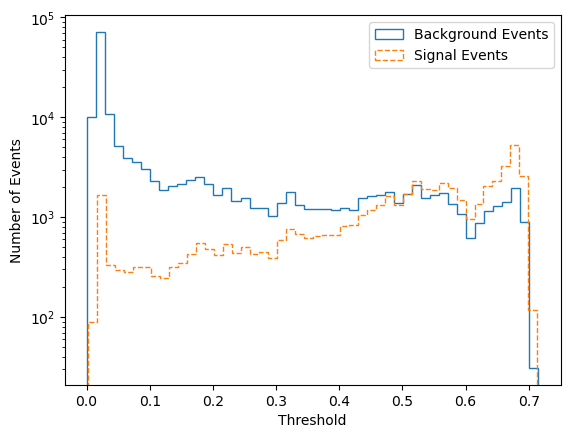

In [28]:
plt.hist(
    decisions_rf[y_test == 0], histtype="step", bins=50, label="Background Events"
)  # plot background
plt.hist(
    decisions_rf[y_test == 1],
    histtype="step",
    bins=50,
    linestyle="dashed",
    label="Signal Events",
)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend

We can separate this plot into two separate histograms (Higgs vs. non Higgs) because we know beforehand which events correspond to the particular type of event. For real data where the answers aren’t provided, it will be one concatenated histogram. The game here is simple: we pick a threshold (i.e. vertical line on the plot). Once we choose that threshold, everything to the right of that vertical line is classified as a signal event, and everything to the left is classified as a background event. By moving this vertical line left and right (i.e. altering the threshold) we effectively change TP, FP, TN and FN. Hence we also change the true positive rate and the false positive rate by moving this line around.

In [29]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test, decisions_rf
)  # get FPRs, TPRs and thresholds for random forest

Suppose we move the threshold from 0 to 1 in steps of 0.01. In doing so, we will get an array of TPRs and FPRs. We can then plot the TPR array vs. the FPR array: this is the ROC curve. To plot the ROC curve, we need to obtain the probabilities that something is classified as a signal (rather than the signal/background prediction itself). This can be done as follows:

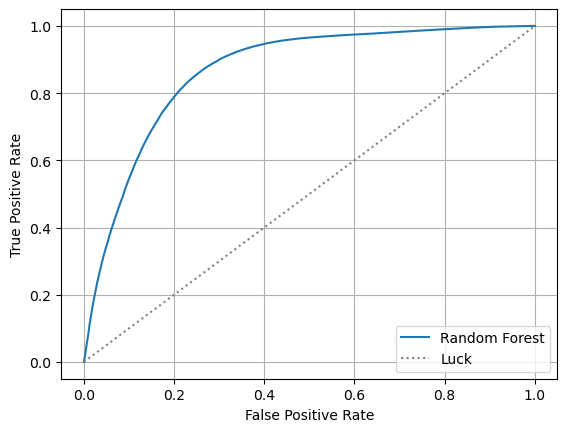

In [30]:
plt.plot(fpr_rf, tpr_rf, label="Random Forest")  # plot random forest ROC
#plt.plot(
#    fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network"
#)  # plot neural network ROC
plt.plot(
    [0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck"
)  # plot diagonal line to indicate luck
plt.xlabel("False Positive Rate")  # x-axis label
plt.ylabel("True Positive Rate")  # y-axis label
plt.grid()  # add a grid to the plot
plt.legend()  # add a legend

## Features Importance

In [45]:
importance = RF_clf.feature_importances_

df1 = pd.DataFrame (importance, columns = ['Importance'])

In [34]:
df2 = pd.DataFrame (ML_inputs, columns = ['Attributes'])

In [37]:
print(ML_inputs)

['lep_pt_1', 'lep_pt_2']


In [39]:
result = pd.concat([df1, df2], axis=1, join='inner')
display(result)

,Importance,Attributes
0,0.497929,lep_pt_1
1,0.502071,lep_pt_2


In [46]:
result = result.sort_values(by='Importance', ascending=False)

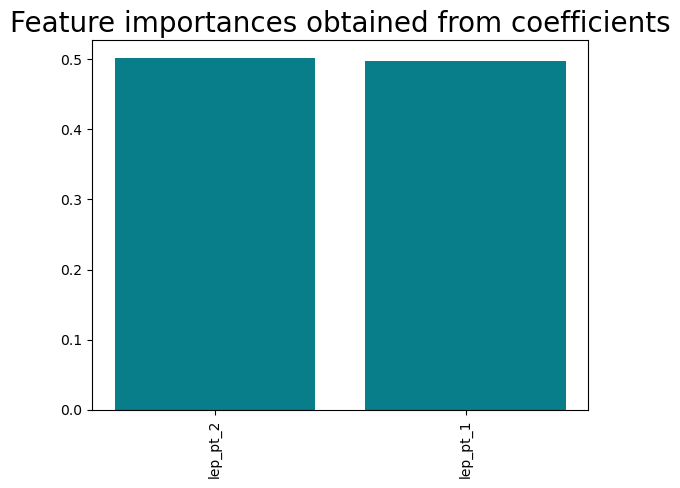

In [56]:
plt.bar(x=result['Attributes'], height=result['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()